In [4]:
import sys
sys.path.append("../")

In [2]:
# some standard packages to assist this tutorial
from pprint import pprint

In [3]:
from compert.train import train_compert
from compert.data import load_dataset_splits
from compert.plotting import CompertVisuals, ComPertHistory
from compert.api import ComPertAPI, get_reference_from_combo
import pandas as pd
import compert.plotting as pl

In [5]:
from os import listdir
from os.path import isfile, join
from os import walk

mypath = '../pretrained_models/'
_, folders, _ = next(walk(mypath))
for fold in folders:
    for f in listdir(join(mypath, fold)):
        if 'GSM_new' in f:
            print(join(mypath, fold, f))

../pretrained_models/GSM/sweep_GSM_new_logsigm_model_seed=60_epoch=1120.pt


In [6]:
# adata = sc.read("./datasets/GSM_new.h5ad")

# Loading pre-trained model

This part is optional if you want to load pre-trained model. The name of the file where the model was saved appears as the last line of the output the train_compert().

In [7]:
import torch
from compert.train import prepare_compert

model_name = '../pretrained_models/GSM/sweep_GSM_new_logsigm_model_seed=60_epoch=1120.pt'
state, args, history = torch.load(model_name, map_location=torch.device('cpu'))
args['dataset_path'] = '../datasets/GSM_new.h5ad'

# load the dataset and model pre-trained weights
autoencoder, datasets = prepare_compert(args, state_dict=state)

In [8]:
compert_api = ComPertAPI(datasets, autoencoder)

In [23]:
%load_ext autoreload
%autoreload 2

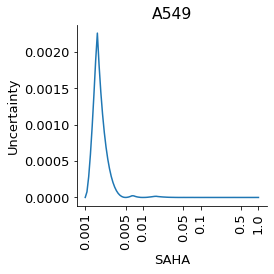

In [27]:
_ = pl.plot_uncertainty_dose(
        compert_api,
        cov='A549',
        pert='SAHA',
        N=101,
        measured_points=compert_api.measured_points['all'],
        cond_key='condition',
        log=True,
        metric='cosine',
        figsize=(4, 4),
        filename='unc_1.svg'
)

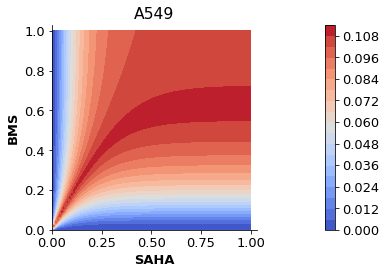

In [22]:
_ = pl.plot_uncertainty_comb_dose(
        compert_api,
        cov='A549',
        pert='SAHA+BMS',
        N=101,
        cond_key='condition',
        metric='cosine',
        filename='unc_2.svg'
)

In [33]:
_, _, _, _, cos_dist, eucl_dist = compert_api.compute_uncertainty(cov='A549', pert='SAHA', dose='0.5')

In [41]:
df_dist = pd.DataFrame({
    'cos_dist': cos_dist, 
    'eucl_dist': eucl_dist,
    'cov/pert': compert_api.comb_emb.obs.cov_pert.apply(lambda x: x.split('_')[1])
})

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

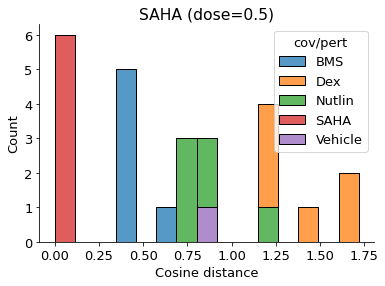

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(x='cos_dist', hue='cov/pert', data=df_dist, bins=15, multiple='stack', ax=ax)
ax.set_xlabel('Cosine distance')
ax.set_title('SAHA (dose=0.5)')
sns.despine()
fig.savefig('unc_3.svg')

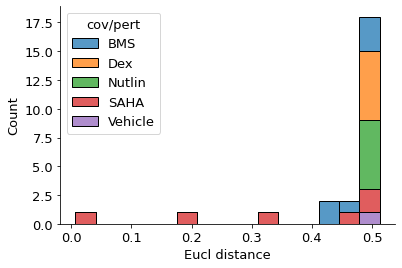

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(x='eucl_dist', hue='cov/pert', data=df_dist, bins=15, multiple='stack', ax=ax)
ax.set_xlabel('Eucl distance')
sns.despine()